In [11]:
import pathlib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib import font_manager as fm
import matplotlib
import seaborn as sns

In [2]:
import os
os.environ['PATH'] += ';C:\\Users\\wilso\\AppData\\Local\\Programs\\MiKTeX\\miktex\\bin\\x64\\'

In [3]:
csv_path = pathlib.Path.cwd() / ".." / "data" / "results.csv"
data = pd.read_csv(csv_path)

In [4]:
data.head()

,Task,Model,Epsilon,AUROC,AUPRC,Accuracy,F1,Params,AR
0,los_3,RF,Benchmark,0.736000,0.685000,0.695000,0.595000,NaN,NaN
1,los_3,RF,Control,0.699201,0.638536,0.656642,0.588176,"{'n_estimators': 410, 'max_depth': 9, 'min_sam...",0.398402
2,los_3,RF,Control,0.698925,0.639058,0.657686,0.584116,"{'n_estimators': 410, 'max_depth': 9, 'min_sam...",0.397849
3,los_3,RF,Control,0.699551,0.639729,0.651629,0.591176,"{'n_estimators': 410, 'max_depth': 9, 'min_sam...",0.399102
4,los_3,RF,Control,0.699103,0.639179,0.655597,0.591933,"{'n_estimators': 410, 'max_depth': 9, 'min_sam...",0.398205


In [5]:
bench_and_control = data.loc[(data["Epsilon"] == "Benchmark")
                             | (data["Epsilon"] == "Control")]
data_epsilons = data.loc[(data["Epsilon"] != "Benchmark")
                             & (data["Epsilon"] != "Control")]
data_epsilons = data_epsilons.astype({"Epsilon": "float64"})

data_epsilons["Composed_Epsilon"] = data_epsilons["Epsilon"] * 105  # 104 is our number of features + 1 for the length of stay time

In [6]:
len(data_epsilons["Epsilon"].unique())

344

In [7]:
l3p = 10303 / 23944
l7p = 1845 / 23944

random_or_dumb_classifier_levels = {"AUROC":
                               {"los_3":
                                    0.5,
                                 "los_7":
                                    0.5,
                                "name": "Random Classifier"},
                            "AUPRC":
                                {"los_3":
                                    l3p,
                                 "los_7":
                                    l7p,
                                "name": "Random Classifier"},
                            "F1":
                                {"los_3":
                                    ((l3p*2) / (1 + l3p)),
                                 "los_7":
                                    ((l7p*2) / (1 + l7p)),
                                "name": "Yes Classifier"},
                            "Accuracy":
                                {"los_3":
                                    (1 - l3p),
                                 "los_7":
                                    (1 - l7p),
                                "name": "No Classifier"},
                            "AR":
                                {"los_3":
                                    0,
                                 "los_7":
                                    0,
                                "name": "Random Classifier"},
                           }

In [8]:
random_or_dumb_classifier_levels

{'AUROC': {'los_3': 0.5, 'los_7': 0.5, 'name': 'Random Classifier'},
 'AUPRC': {'los_3': 0.4302956899432008,
  'los_7': 0.07705479452054795,
  'name': 'Random Classifier'},
 'F1': {'los_3': 0.6016877390720354,
  'los_7': 0.14308426073131955,
  'name': 'Yes Classifier'},
 'Accuracy': {'los_3': 0.5697043100567992,
  'los_7': 0.922945205479452,
  'name': 'No Classifier'},
 'AR': {'los_3': 0, 'los_7': 0, 'name': 'Random Classifier'}}

In [9]:
SMA = {"LR": {
            "los_3": {},
            "los_7": {}
},
       "RF": {
            "los_3": {},
            "los_7": {}
       }}

In [10]:
target_translate = {
    "los_3": "3 day length-of-stay",
    "los_7": "7 day length-of-stay",
    "RF": "Random Forest",
    "LR": "Logistic Regression"
}

In [12]:
fe = fm.FontEntry(
    fname='Montserrat-Regular.ttf',
    name='Montserrat')
fm.fontManager.ttflist.insert(0, fe) # or append is fine
matplotlib.rcParams['font.family'] = fe.name # = 'your custom ttf font name'

In [22]:
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
         "font.size": "16"}
plt.rcParams.update(params)

In [59]:


def plot_models(y, target, log_x=True, min_x=None, max_x=None):
    df = data_epsilons.loc[data_epsilons["Task"] == target]
    

    for i, model in enumerate(df.Model.unique()):
        fig, ax = plt.subplots()
        
        fig.set_facecolor("k")        

        b_and_c = bench_and_control.loc[(bench_and_control["Model"] == model) & (bench_and_control["Task"] == target)]
        benchmark = b_and_c.loc[b_and_c["Epsilon"] == "Benchmark"]
        control = b_and_c.loc[b_and_c["Epsilon"] == "Control"]
        ax.axhline(y=benchmark[y].mean(), label="Benchmark", c="limegreen", linestyle="dashed")
        ax.axhline(y=control[y].mean(), label="Control", c="red", linestyle="dashed")
        
        ax.axhline(y = random_or_dumb_classifier_levels[y][target], label=random_or_dumb_classifier_levels[y]["name"], c="gold", linestyle="dashed")

        dot_size = 80
        df.loc[df["Model"] == model].plot(x="Composed_Epsilon", y=y, kind="scatter", ax=ax, logx=log_x, color="r", figsize=(14,10), s=dot_size, alpha=.7)
        
        
        # SMA
        smooth_points = 30
        smooth_path = df.loc[df["Model"] == model].set_index("Composed_Epsilon").sort_index().rolling(smooth_points, center=True).mean()[y]
        SMA[model][target][y] = smooth_path
        path_deviation = 2 * df.loc[df["Model"] == model].set_index("Composed_Epsilon").sort_index().rolling(smooth_points, center=True).std()[y]
        under_line = (smooth_path-path_deviation)
        over_line = (smooth_path+path_deviation)
        ax.plot(smooth_path, linewidth=2, color="b", label="Moving Average")
        ax.fill_between(path_deviation.index, under_line, over_line, color='r', alpha=.25)
        

        ax.set_xlim(min_x, max_x)
        ax.set_xlabel("Epsilon")
        ax.invert_xaxis()
        ax.grid(which="both", axis="x")
        ax.grid(which="major", axis="y")
        
        
        
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
        ax.legend(loc=3, framealpha=1, labelcolor="w", facecolor="black")

        y_locator = ticker.LinearLocator(numticks=15) 
        ax.yaxis.set_major_locator(y_locator)
    
        fig.suptitle("{} for model {} on target {}".format(y, target_translate[model], target_translate[target]), fontsize=24, color="w")
        plt.show()
        fig.savefig(target + "_" + model + "_" + y + ".png", transparent=True)

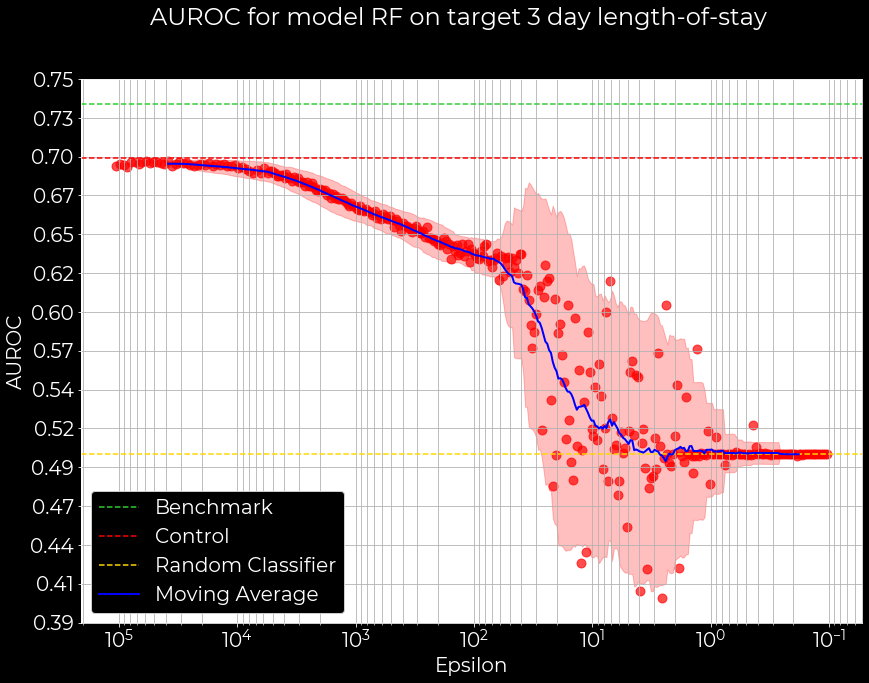

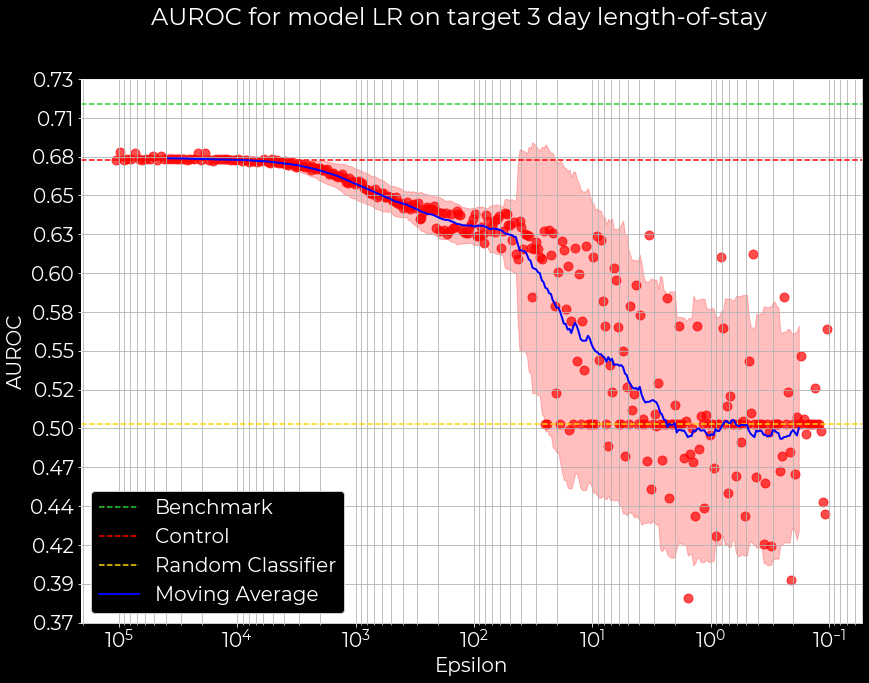

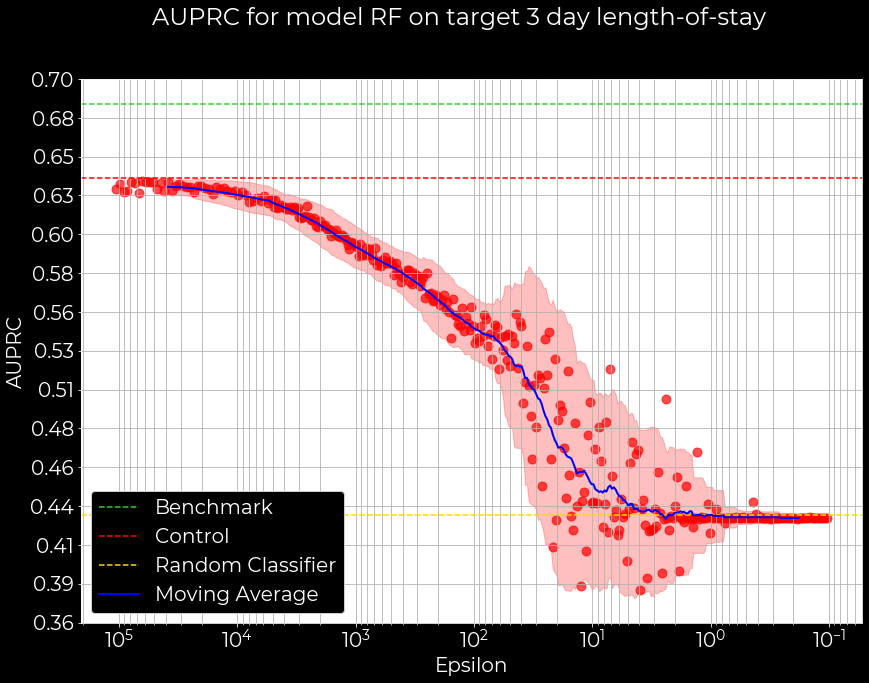

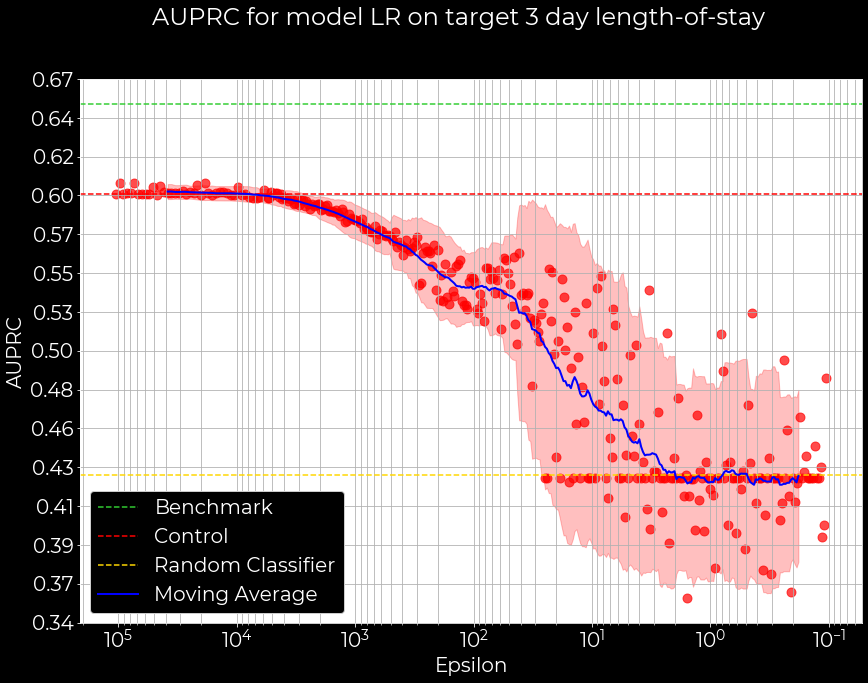

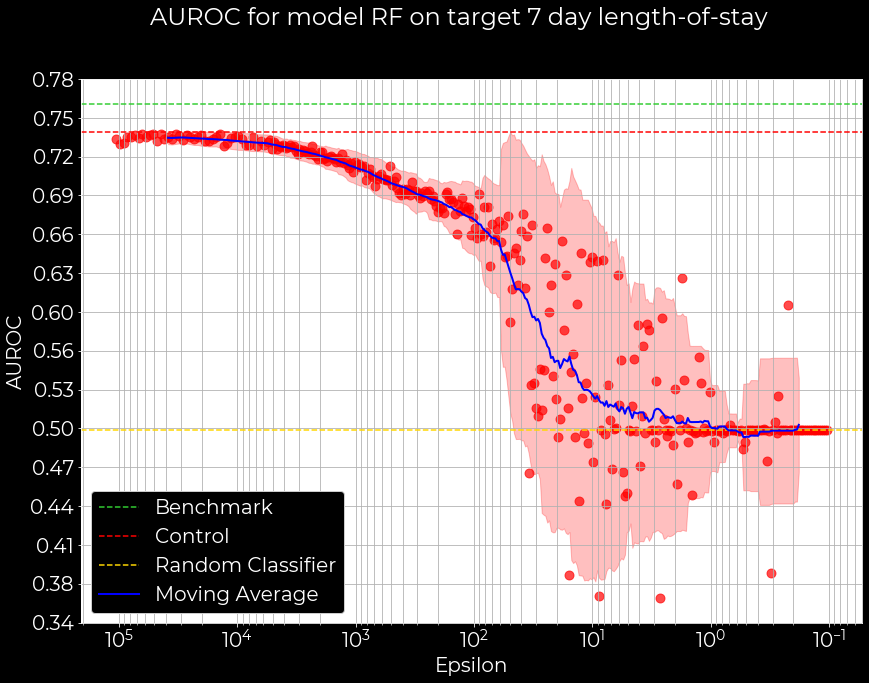

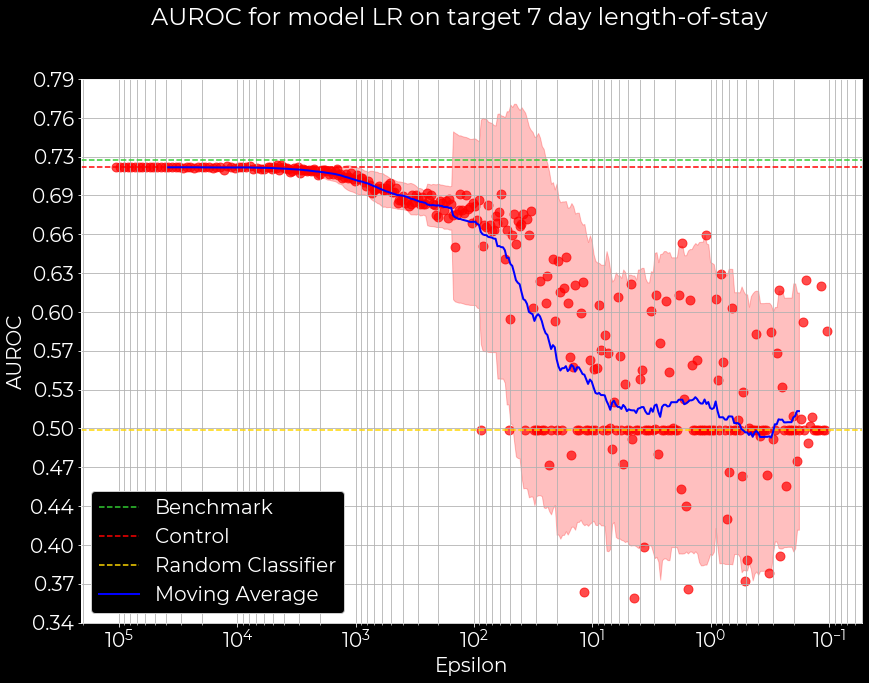

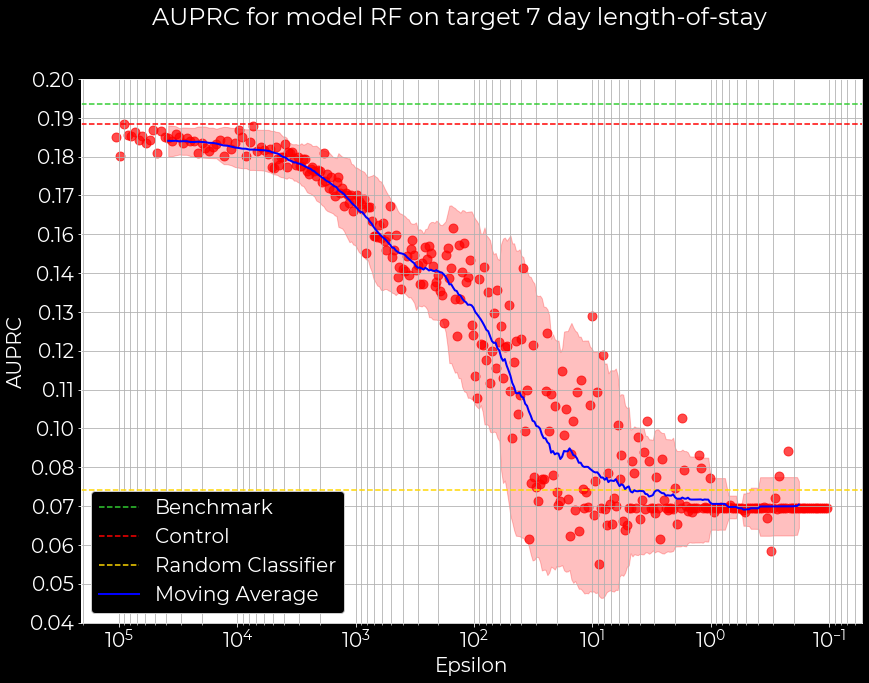

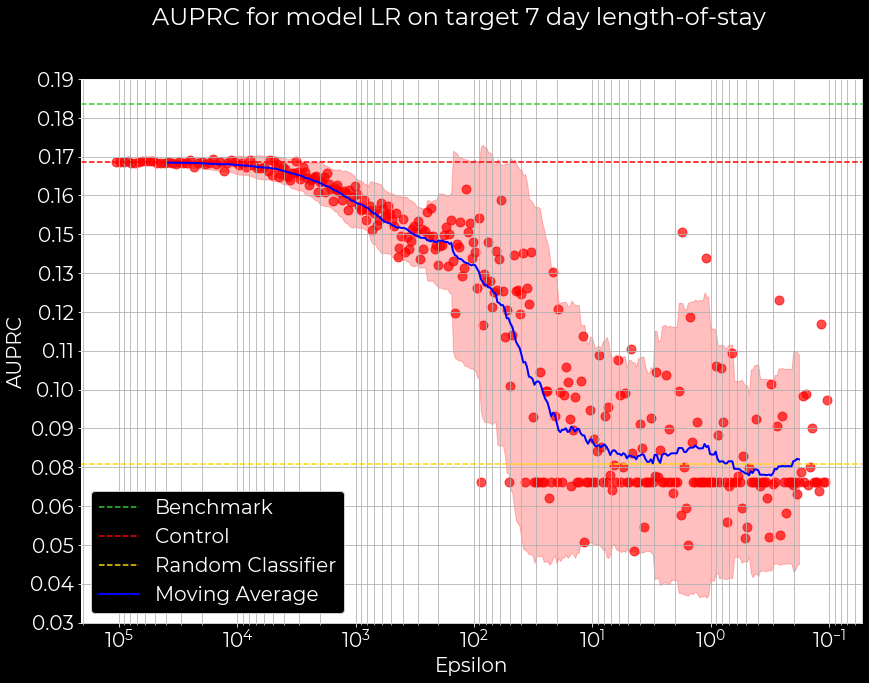

In [60]:
plot_models("AUROC", "los_3")
plot_models("AUPRC", "los_3")
plot_models("AUROC", "los_7")
plot_models("AUPRC", "los_7")

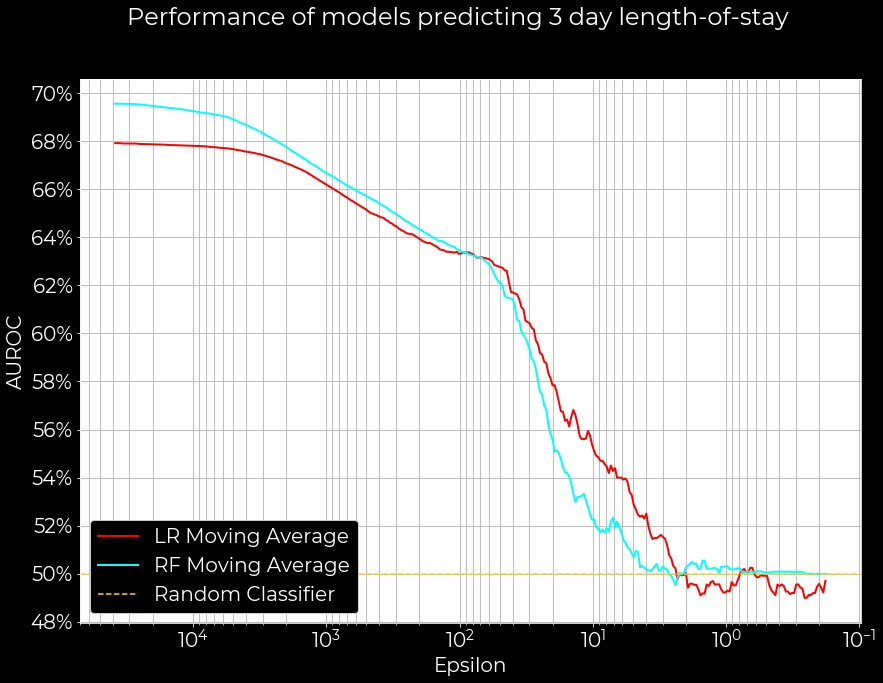

In [69]:
fig, ax = plt.subplots()

fig.set_facecolor("k") 

ax.plot(SMA["LR"]["los_3"]["AUROC"], linewidth=2, color="r", label="LR Moving Average")
ax.plot(SMA["RF"]["los_3"]["AUROC"], linewidth=2, color="cyan", label="RF Moving Average")

ax.axhline(y = random_or_dumb_classifier_levels["AUROC"]["los_3"], label=random_or_dumb_classifier_levels["AUROC"]["name"], c="gold", linestyle="dashed")

ax.set_ylabel("AUROC")
ax.set_xlabel("Epsilon")
ax.invert_xaxis()
ax.grid(which="both", axis="x")
ax.grid(which="major", axis="y")
ax.legend(loc=3, framealpha=1, labelcolor="w", facecolor="black")

ax.set_xscale("log", base=10)

y_locator = ticker.MaxNLocator(15)
ax.yaxis.set_major_locator(y_locator)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, 0))

fig.suptitle("Performance of models predicting 3 day length-of-stay", fontsize=24, color="w")
fig.set_size_inches(14, 10)
plt.show()
fig.savefig("RF_LR_SMA" + ".png", transparent=True)

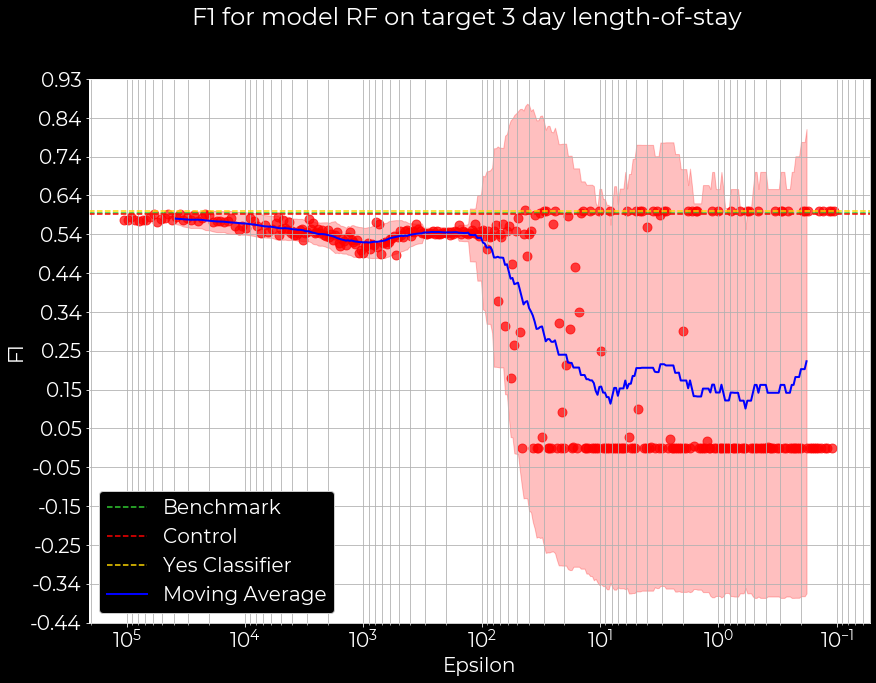

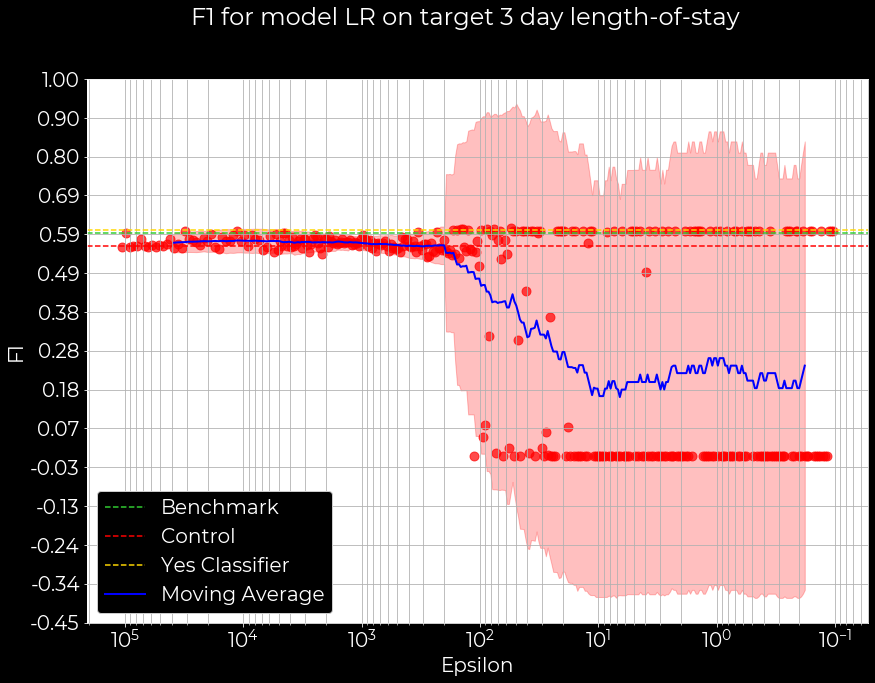

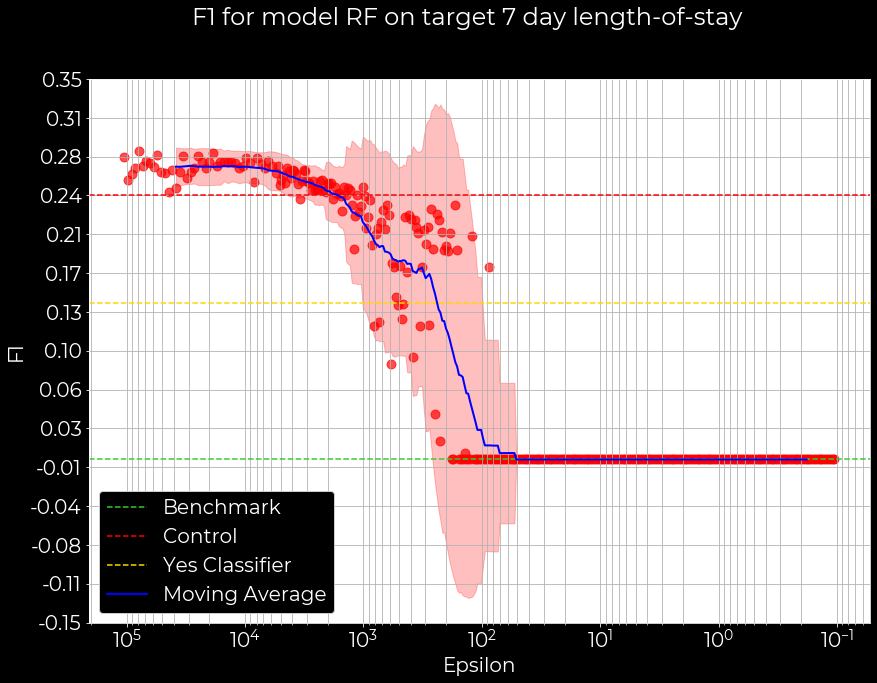

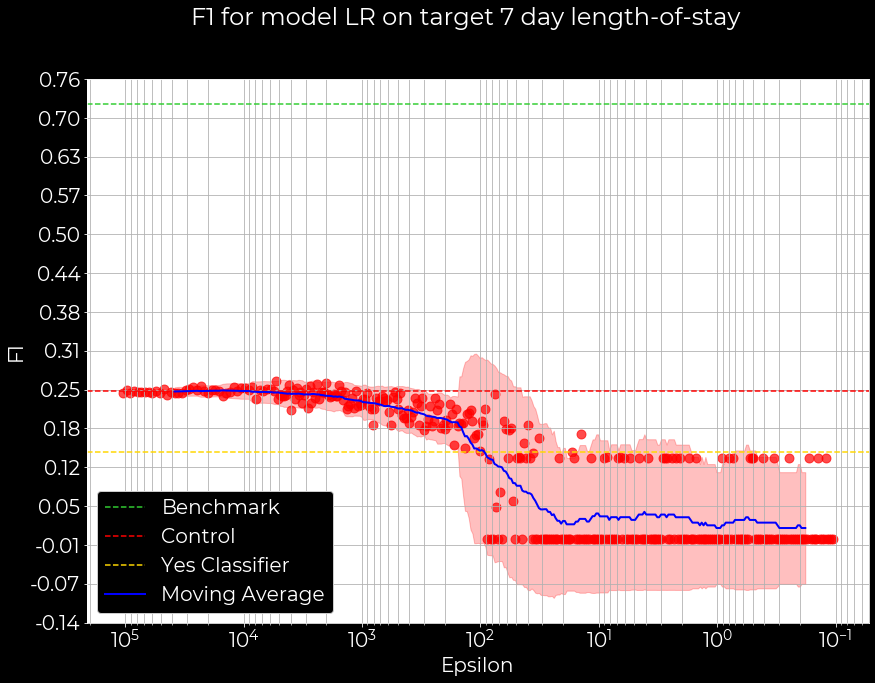

In [62]:
plot_models("F1", "los_3")
plot_models("F1", "los_7")
# plot_models("F1", "los_3", False, 10.4, 520)

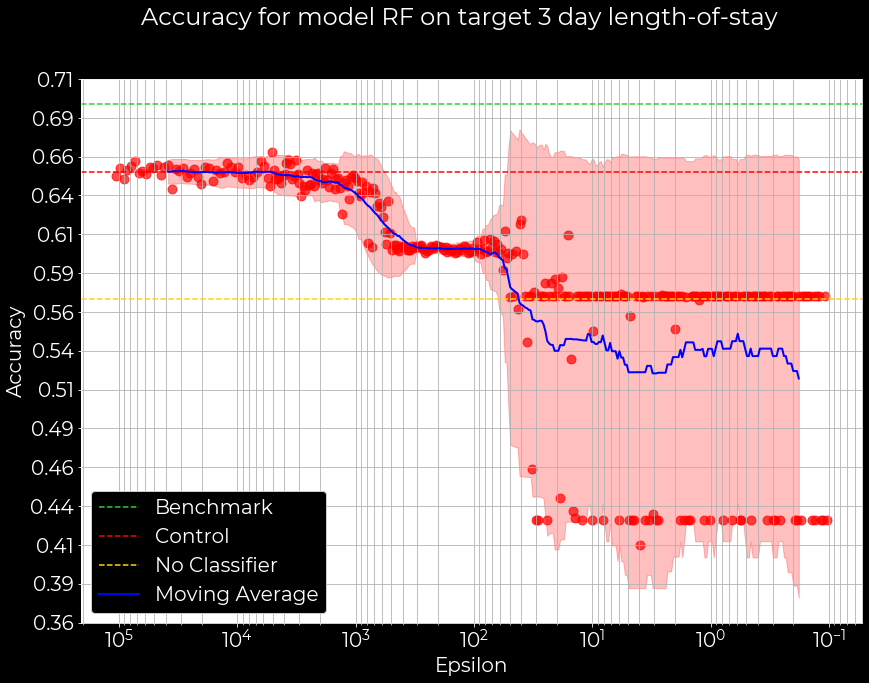

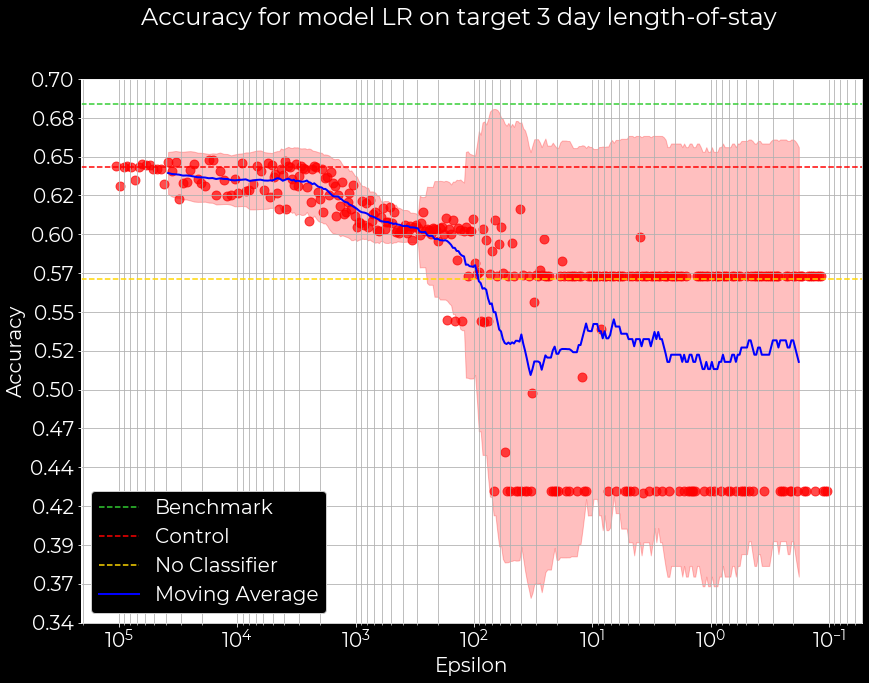

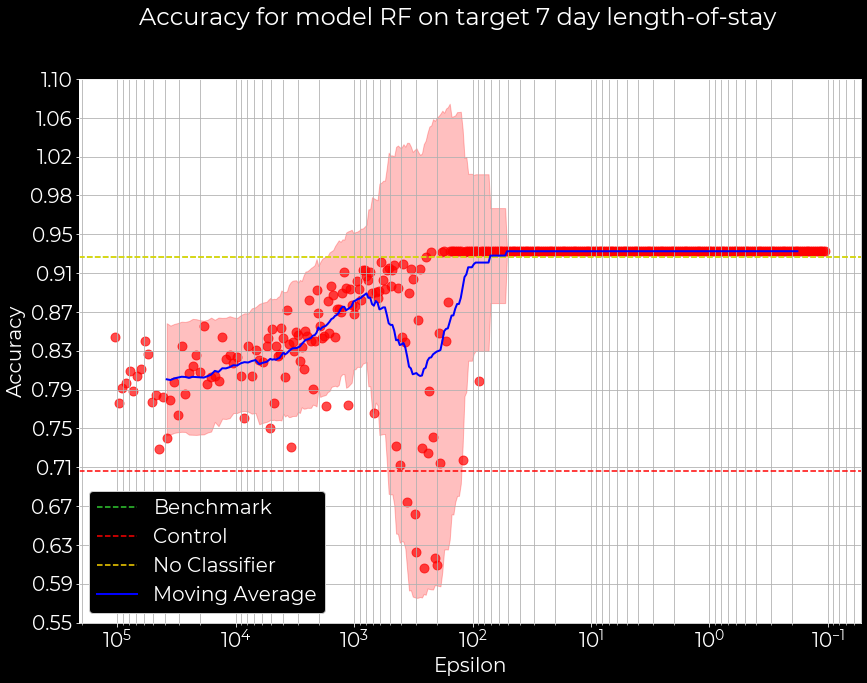

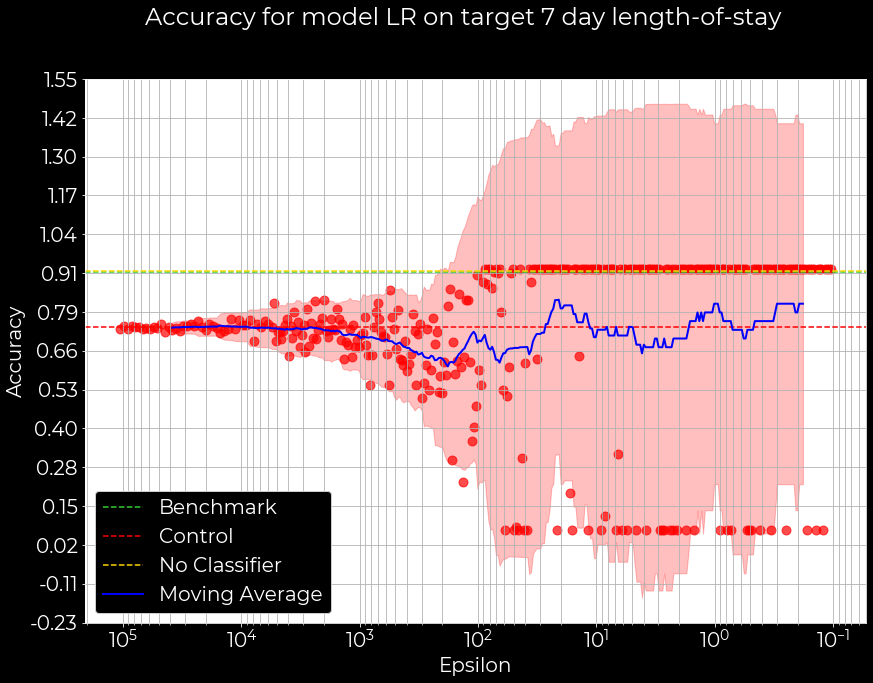

In [63]:
plot_models("Accuracy", "los_3")
plot_models("Accuracy", "los_7")

In [13]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})